In [9]:
import nest
import numpy as np
import pylab as pl
from sklearn.linear_model import LinearRegression
def compute_capacity(state_mat, signal):
    """
    Compute capacity to reconstruct y based on linearly combining a
    :param a: state matrix (NxT)
    :param y: target output (1xT)
    :return y_hat: estimated signal
    :return capacity: 
    :return error:
    """
    state_mat = state_mat.T
    signal_pred = LinearRegression(n_jobs=-1, fit_intercept=False, normalize=True, copy_X=False).fit(state_mat, signal).predict(state_mat)
    MSE_pred = np.mean((signal-signal_pred)**2)
    return signal_pred, 1. - (MSE_pred / np.var(signal)), MSE_pred
        

In [2]:
# parameters
T = 1000  # total number of time steps
dt = 0.1  # simulation resolution
nEnc = 1000 # neurons encoding layer
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.

# randomize thresholds and initial states
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

### Check which neuron model is better depending on the duration of the stimulus

In [ ]:
for neuron_model in [0, 1]:
    u_vals = 0.
    for d_vals in range(10,110,10):
        # Initialize NEST
        np.random.seed(42)
        nest.ResetKernel()
        nest.SetKernelStatus({
            'resolution': dt,
            'print_time': True,
            'local_num_threads': 8})

        # Input parameters
        u_range = [u_vals, 1.]
        duration = float(d_vals) # [ms]

        u = np.random.uniform(low=u_range[0], high=u_range[1], size=T)
        input_times = np.arange(dt, T*duration, duration)

        if neuron_model==0:
            neuron_params = {'C_m': 250.0,
                             'Delta_T': 2.0,
                             'E_L': -70.,
                             'E_ex': 0.0,
                             'E_in': -75.0,
                             'I_e': 0.,
                             'V_m': -70.,
                             'V_th': -50.,
                             'V_reset': -60.0,
                             'V_peak': 0.0,
                             'a': 4.0,
                             'b': 80.5,
                             'g_L': 16.7,
                             'g_ex': 1.0,
                             'g_in': 1.0,
                             't_ref': 2.0,
                             'tau_minus': 20.,
                             'tau_minus_triplet': 200.,
                             'tau_w': 144.0,
                             'tau_syn_ex': 2.,
                             'tau_syn_in': 6.0}

            nest.SetDefaults('aeif_cond_exp', neuron_params)
            enc_layer = nest.Create('aeif_cond_exp ', nEnc, {'I_e': J_bias})

        elif neuron_model==1:

            enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})

        step_generator = nest.Create('step_current_generator', nEnc)
        amplitudes = np.zeros((nEnc, len(u)))

        for n in range(nEnc):
            amplitudes[n, :] = u * tuning[n]
            nest.SetStatus([enc_layer[n]], {'V_m': Vm0[n], 'V_th': thresholds[n]})
            nest.SetStatus([step_generator[n]], {'amplitude_times': input_times,
                                                 'amplitude_values': amplitudes[n]})
            nest.Connect([step_generator[n]], [enc_layer[n]])

        enc_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval':dt})
        nest.Connect(enc_v, enc_layer)

        nest.Simulate(T*duration+dt)

        time_vector = np.arange(0., T*duration, dt)

        signal = np.zeros_like(time_vector)

        for tt in range(len(input_times)-1):
            signal[int(input_times[tt]/dt):int(input_times[tt+1]/dt)] = u[tt]

        enc_activity = nest.GetStatus(enc_v)[0]['events']

        enc_indices = np.sort(np.unique(enc_activity['senders']))
        enc_states = np.zeros((nEnc, int(T*duration/dt)))
        for idx, i in enumerate(enc_indices):
            enc_states[idx, :] = enc_activity['V_m'][np.where(enc_activity['senders']==i)[0]]

        max_lag = 30.   # [ms] in this example
        step_lag = 10.   # [ms] - if != dt (index the time axis)
        time_lags = np.arange(0., max_lag, step_lag)
        indices = [np.where(idx==time_vector)[0][0] for idx in time_lags]

        encoder_capacity = []

        for idx, lag in zip(indices, time_lags):

            # shift the target signal
            if idx > 0:
                shifted_signal = signal[:-idx]
            else:
                shifted_signal = signal

            # shift the population states
            enc_st = enc_states[:, idx:]

            # compute capacity
            enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)

            with open ("resultsParamAndDur.csv","a") as results_file:
                results_file.write("{0},{1},{2},{3},{4},{5}\n".format(
                    str(neuron_model), str(u_vals), str(d_vals),str(lag), str(enc_capacity), str(enc_error)))

            results_file.close()

            print("Lag = {0} ms".format(str(lag)))
            print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))

            encoder_capacity.append(enc_capacity)

        print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.609122189422273, MSE=0.03341896050763369
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.7075463160346638, MSE=0.024958777769587145
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.3224894439028526, MSE=0.05773533819821886
Total capacity (encoder): 16.391579493597895 ms
Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.7550041357675481, MSE=0.020946855728931082
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.8359195637357666, MSE=0.01401599862468964
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.6024976664739154, MSE=0.033924442624095545
Total capacity (encoder): 21.9342136597723 ms
Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.8150097948006488, MSE=0.015816228822642893
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.885054761824764, MSE=0.009821627049283018
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.7083674401607865, MSE=0.024903828052224814
Total capacity (encoder): 24.08431996786199 ms


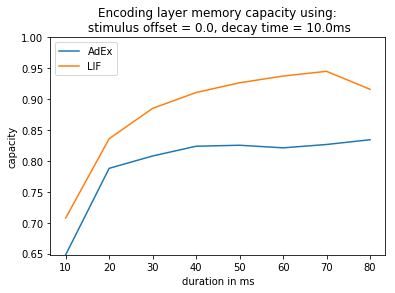

In [3]:
select_lag=1

data_ad_ex = np.loadtxt("resultsParamAndDurAdExU0.csv", delimiter=',')
data_lif = np.loadtxt("resultsParamAndDurLifU0.csv", delimiter=',')

plt_ad_ex = pl.plot(data_ad_ex[range(1,len(data_ad_ex),3),2],data_ad_ex[range(1,len(data_ad_ex),3),4])
plt_lif = pl.plot(data_lif[range(1,len(data_lif),3),2],data_lif[range(1,len(data_lif),3),4])

pl.title("Encoding layer memory capacity using:\n stimulus offset = {0}, decay time = {1}ms".format(str(data_lif[0,1]), str(data_lif[select_lag,3])))
pl.xlabel('duration in ms')
pl.ylabel('capacity')
pl.ylim(min([min(data_ad_ex[range(1,len(data_ad_ex),3),4]), min(data_lif[range(1,len(data_lif),3),4])]), 1)
pl.legend(('AdEx', 'LIF'))

0.6479917558322584

### check stimulus offset for better model

In [ ]:
neuron_model = 1
for u_vals in [0.1, 0.2, 0.3, 0.4, 0.5]:
    d_vals = 70
    # Initialize NEST
    np.random.seed(42)
    nest.ResetKernel()
    nest.SetKernelStatus({
        'resolution': dt,
        'print_time': True,
        'local_num_threads': 8})

    # Input parameters
    u_range = [u_vals, 1.]
    duration = float(d_vals) # [ms]

    u = np.random.uniform(low=u_range[0], high=u_range[1], size=T)
    input_times = np.arange(dt, T*duration, duration)

    enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})

    step_generator = nest.Create('step_current_generator', nEnc)
    amplitudes = np.zeros((nEnc, len(u)))

    for n in range(nEnc):
        amplitudes[n, :] = u * tuning[n]
        nest.SetStatus([enc_layer[n]], {'V_m': Vm0[n], 'V_th': thresholds[n]})
        nest.SetStatus([step_generator[n]], {'amplitude_times': input_times,
                                             'amplitude_values': amplitudes[n]})
        nest.Connect([step_generator[n]], [enc_layer[n]])

    enc_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval':dt})
    nest.Connect(enc_v, enc_layer)

    nest.Simulate(T*duration+dt)

    time_vector = np.arange(0., T*duration, dt)

    signal = np.zeros_like(time_vector)

    for tt in range(len(input_times)-1):
        signal[int(input_times[tt]/dt):int(input_times[tt+1]/dt)] = u[tt]

    enc_activity = nest.GetStatus(enc_v)[0]['events']

    enc_indices = np.sort(np.unique(enc_activity['senders']))
    enc_states = np.zeros((nEnc, int(T*duration/dt)))
    for idx, i in enumerate(enc_indices):
        enc_states[idx, :] = enc_activity['V_m'][np.where(enc_activity['senders']==i)[0]]

    max_lag = 30.   # [ms] in this example
    step_lag = 10.   # [ms] - if != dt (index the time axis)
    time_lags = np.arange(0., max_lag, step_lag)
    indices = [np.where(idx==time_vector)[0][0] for idx in time_lags]

    encoder_capacity = []

    for idx, lag in zip(indices, time_lags):

        # shift the target signal
        if idx > 0:
            shifted_signal = signal[:-idx]
        else:
            shifted_signal = signal

        # shift the population states
        enc_st = enc_states[:, idx:]

        # compute capacity
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)

        with open ("resultsParamAndDur.csv","a") as results_file:
            results_file.write("{0},{1},{2},{3},{4},{5}\n".format(
                str(neuron_model), str(u_vals), str(d_vals),str(lag), str(enc_capacity), str(enc_error)))

        results_file.close()

        print("Lag = {0} ms".format(str(lag)))
        print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))

        encoder_capacity.append(enc_capacity)

    print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.9134450675597356, MSE=0.0047531554310097646
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.9444109506103788, MSE=0.0030503225877192685
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.8700078473188797, MSE=0.00712753769268039
Total capacity (encoder): 27.278638654889946 ms


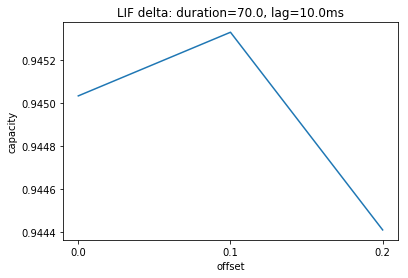

In [8]:
select_lag=1
d_vals = 70
data_lif = np.loadtxt("resultsParamAndDurLifU0.csv", delimiter=',')
inds=np.where(data_lif[:,2]==d_vals)
data_lif = np.concatenate((data_lif[inds[0],:], np.loadtxt("resultsParamAndDurLifD70.csv", delimiter=',')))

pl.plot(data_lif[range(1,len(data_lif),3),1],data_lif[range(1,len(data_lif),3),4])

pl.title("LIF delta: duration={0}, lag={1}ms".format(str(data_lif[0,2]), str(data_lif[select_lag,3])))
pl.xlabel('offset')
pl.xticks(data_lif[range(1,len(data_lif),3),1])
pl.ylabel('capacity')
pl.savefig('test.png')